# Imports and read main Dataset

## Problem Statement: Wildlife Telemetry datasets often suffer from missing or irregularly sampled data as a result of environmental factors, such as natural barriers. 

## Contributions:
### We design an efficient framework for imputing wildlife trajectories. The literature for wildlife trajectory imputation is limited and the existing work is constrained by the computational complexity of GPs.
### As a key step in our framework, we propose a temporal-aware clustering mechanism for home-range identification to isolate the behavior of wildlife based on the season. Compared to an indiscriminate trajectory modelling, we observed considerable performance and accuracy gains in the imputation task.
### We analyze the use of random Fourier features to construct a kernel efficiently and further reducing the Gaussian Process modelling into a trivial task. To the best of our knowledge, random Fourier features have not been studies with respect to Gaussian Process trajectory analysis in any capacity.

In [3]:
# Imports and read main Dataset

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from util import plotting
from util import clustering

from datetime import datetime
from sklearn.model_selection import train_test_split
import os, sys
os.chdir(sys.path[0])
#os.getcwd()

In [5]:
df = pd.read_csv ('data/kruger.ndvi.csv')
df = df[df['individual-local-identifier'] == 'AM99']

### Compute delta_abs = time in seconds from first trajectory point
### Compute delta = time in seconds from Jan 1 of the same year
### Compute month-day

In [6]:
df['date-obj']=pd.to_datetime(df['timestamp'])
#plt.plot(df['date-obj'], df['location-long'], label='Longitude')
first_date = df['date-obj'].iloc[0]
epoch_time = datetime(2000, 1, 1)
epoch_time2 = datetime(2001, 1, 1)
secondsInyear = (epoch_time2-epoch_time).total_seconds()

df["delta_abs"] = (df['date-obj']-first_date).dt.total_seconds()
df["delta"] = df['date-obj']-epoch_time2
df["delta"] = df["delta"].dt.total_seconds()%secondsInyear
df["delta_hour"] = df["delta"].div(3600).astype(int)
df["delta_min"] = df["delta"].div(60).astype(int)
df["delta_day"] = df["delta_hour"].div(24).astype(int)

# Month / Day irrespective of year
df["month-day"] = df['date-obj'].dt.strftime('%m%d')

#secondsInyear
#df["month-day"]

### Compute Distance in KM from first trajectory point

In [7]:
from geopy.distance import geodesic as GD
first_row = tuple([df.iloc[0]['location-lat'], df.iloc[0]['location-long']])
df['distance'] = 0
for index, row in df.iterrows():
    if index == 0:
        #first_row = row
        #prev_row = row
        continue
    df.at[index,'distance'] = GD((row['location-lat'], row['location-long']),first_row).km
    #df.at[index,'delta'] = GD((row['location-lat'], row['location-long']),(prev_row['location-lat'], prev_row['location-long'])).km
    #prev_row = row

In [8]:
### Scale cluster points
#subset = df[["location-long", "location-lat", "delta_min", "distance", "delta_day"]]
#scaled = StandardScaler().fit_transform(subset)
#scaled

# Cluster with DBSCAN & PLOT

In [9]:
MP = 45
RADIUS = 0.17

clusters, centroids = clustering.get_clusters(df, 
                                    ["location-long", "location-lat", "delta_min"],
                                    method="DBSCAN",
                                       r=RADIUS, mp=MP, 
                                    noise=True
                                    )

#print(centroids)
#clusters
occur = clusters.groupby(['cluster']).size()
occur
result = df.groupby('cluster').agg({'month-day': ['min', 'max', 'count']})


from IPython.display import HTML
pd.set_option("display.max_rows", 120, "display.max_columns", 10)

#HTML(result.to_html(index=False))
print(result)
#clusters[clusters['cluster']==10]['delta'].min()
#clusters['month-day'] = clusters['del']

        month-day            
              min   max count
cluster                      
-1           0101  1231  3106
 0           0219  0816  7877
 1           0726  0819   458
 2           0802  1101  1186
 3           0819  0831   450
 4           0905  1214  3359
 5           0918  0920    57
 6           0915  0919    99
 7           0924  0929   173
 8           1013  1111  1065
 9           1105  1108    72
 10          1106  1120   218
 11          1117  1127   275
 12          0101  1231  1521
 13          0103  1218    65
 14          0107  0220  2572
 15          0130  0310   987
 16          0221  0408  1149
 17          0328  0403    64
 18          0327  0408    29
 19          0427  0508   202
 20          0512  0611   853
 21          0524  0804   396
 22          0726  0802   141
 23          0803  0804    51
 24          0806  0826   859
 25          0831  0901    60
 26          0902  0903    45
 27          0903  0913   454
 28          0921  1020    75
 29       

C:\research\wildlife\ee\pythonProject\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


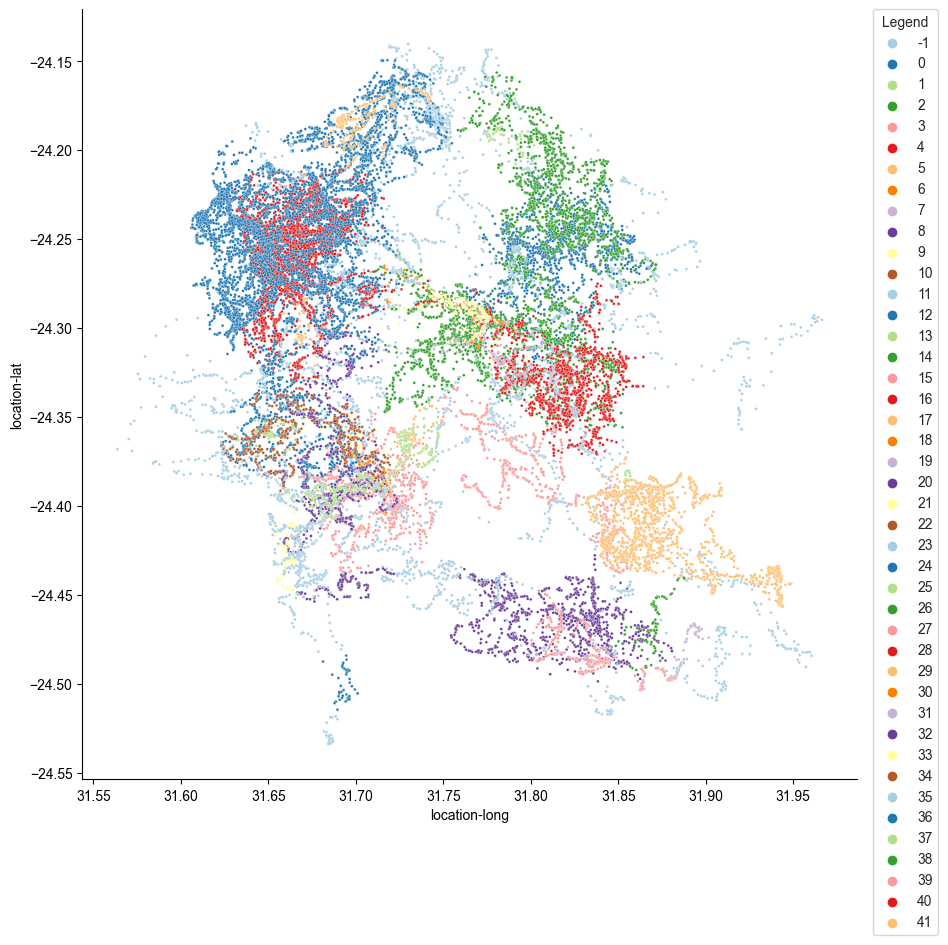

In [10]:
#fig, axs = plt.subplots(nrows=1, ncols=1)
clustering.plot_range(clusters, centroids,  show=False)
#axs.set_title("DBSCAN")
plt.show()

## Select cluster  

In [11]:
CLUSTER = 41

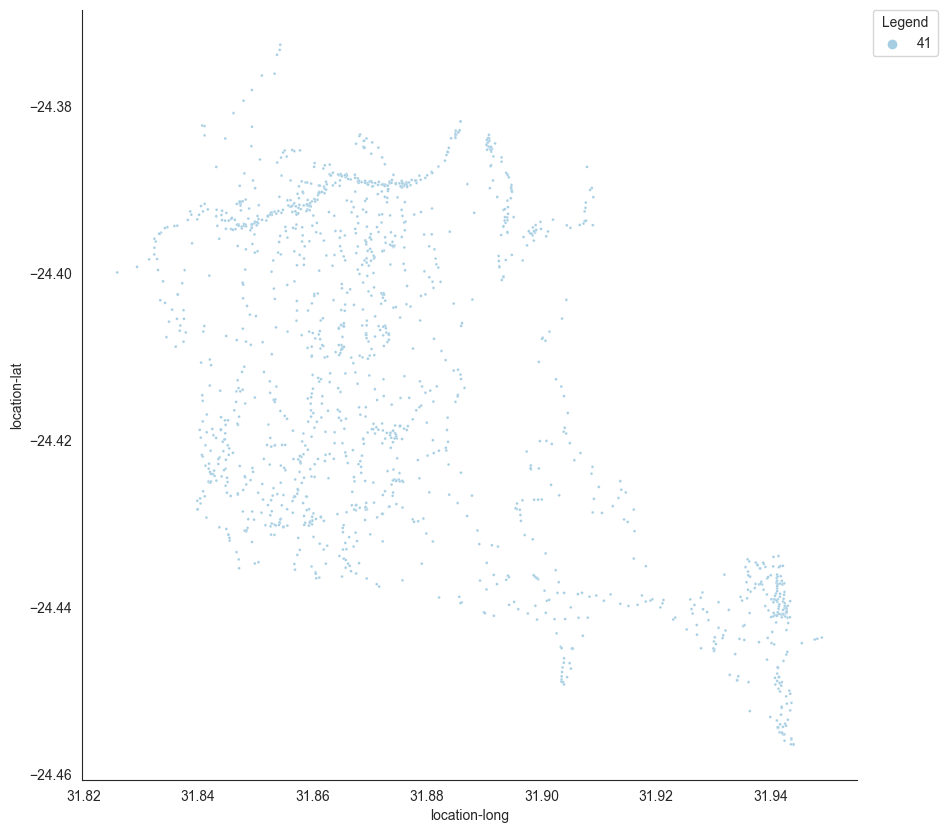

In [12]:
clustering.plot_range(clusters[clusters['cluster']==CLUSTER], centroids,  show=False)
#axs.set_title("DBSCAN")
plt.show()

# RUN MULTI-OUTPUT GPR
#### Feinberg, Vladimir, et al. "Large linear multi-output gaussian process learning." arXiv preprint arXiv:1705.10813 (2017).

In [13]:
%env OMP_NUM_THREADS=1

import os, sys
if os.path.basename(os.getcwd()) != 'runlmc':
    os.chdir('..')
sys.path.append('benchmarks/benchlib')
import numpy as np

from runlmc.models.interpolated_llgp import InterpolatedLLGP
from runlmc.lmc.functional_kernel import FunctionalKernel
from runlmc.kern.rbf import RBF

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)

from runlmc.models.optimization import AdaDelta


env: OMP_NUM_THREADS=1


### Prep Data and split to train/test

In [14]:
df2 = df[df['cluster'] == 40]
df2["delta_abs_normalized"] = df2["delta_abs"] /100000/60
df2["delta_abs_min"] = df2["delta_abs"] /60

train, test = train_test_split(df2, test_size=0.1)
train = train.sort_values(by='delta_abs', ascending=True)
test = test.sort_values(by='delta_abs', ascending=True)

TRAIN_SIZE = len(train)
TEST_SIZE = len(test)
print ("Train size =", TRAIN_SIZE, " Test size=", TEST_SIZE)

Train size = 392  Test size= 44


C:\Users\ITA223.490INFRA6JQJ\AppData\Local\Temp\ipykernel_34780\968288476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["delta_abs_normalized"] = df2["delta_abs"] /100000/60
C:\Users\ITA223.490INFRA6JQJ\AppData\Local\Temp\ipykernel_34780\968288476.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["delta_abs_min"] = df2["delta_abs"] /60


In [15]:
Xs_train = train['delta_abs_normalized'].to_numpy().reshape(-1,1)
ys_train1 = train['location-long'].to_numpy().reshape(-1, 1)
ys_train2 = train['location-lat'].to_numpy().reshape(-1, 1)

y_train1_mean = ys_train1.mean(axis = 0)
y_train2_mean = ys_train2.mean(axis = 0)
ys_train1 = ys_train1 - y_train1_mean
ys_train2 = ys_train2- y_train2_mean

Xs_test  = test['delta_abs_normalized'].to_numpy().reshape(-1,1)
ys_test1  = test['location-long'].to_numpy().reshape(-1,1)
ys_test2  = test['location-lat'].to_numpy().reshape(-1,1)
ys_test1 = ys_test1 - y_train1_mean
ys_test2 = ys_test2 - y_train2_mean

xss = Xs_train.reshape(1,TRAIN_SIZE)
yss1 = ys_train1.reshape(1,TRAIN_SIZE)
yss2 = ys_train2.reshape(1,TRAIN_SIZE)
yss = [yss1[0], yss2[0]]
xss = [xss[0], xss[0]]

#print(yss)
#print(xss)

### This will take some time

In [16]:
import GPy
nout = 2

rbfs = [GPy.kern.RBF(1) for _ in range(nout)]
# not exactly the same since mine is rank-1 only for now
# This is why we need as many kernels as outputs, because we'd be rank-deficient o/w
k = GPy.util.multioutput.LCM(input_dim=1,num_outputs=nout,kernels_list=rbfs)
xss_reshaped = [xs.reshape(-1, 1) for xs in xss]
yss_reshaped = [ys.reshape(-1, 1) for ys in yss]
m = GPy.models.GPCoregionalizedRegression(
    xss_reshaped, yss_reshaped, kernel=k)
m.optimize()
#print(yss_reshaped)
#print(m)

[392 784]


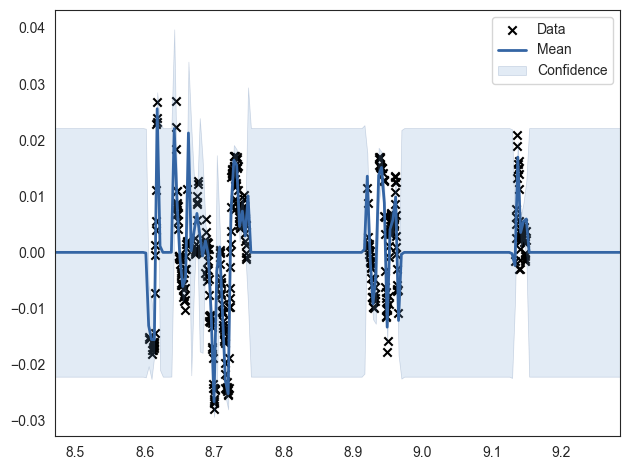

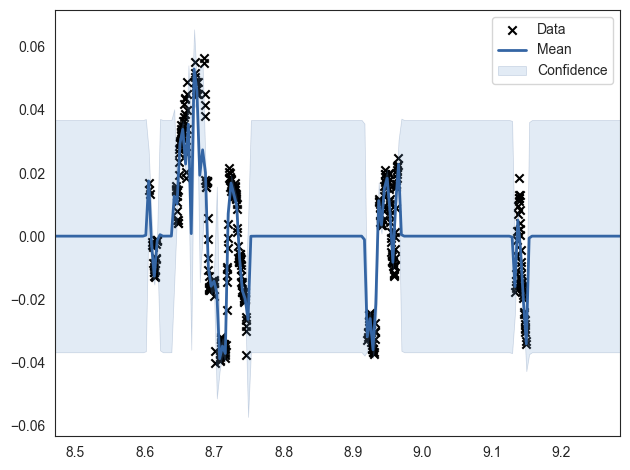

In [17]:
n_per_output = [TRAIN_SIZE, TRAIN_SIZE]
data_rows = np.add.accumulate(n_per_output)
print(data_rows)
data_rows = np.insert(data_rows, 0, 0)

for i in range(nout):
    m.plot(
#        plot_limits=(0, 1),
        fixed_inputs=[(1,i)],
        which_data_rows=slice(data_rows[i],data_rows[i + 1]))
    

# RUN VANILLA GPR 

 C:\research\wildlife\ee\pythonProject\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


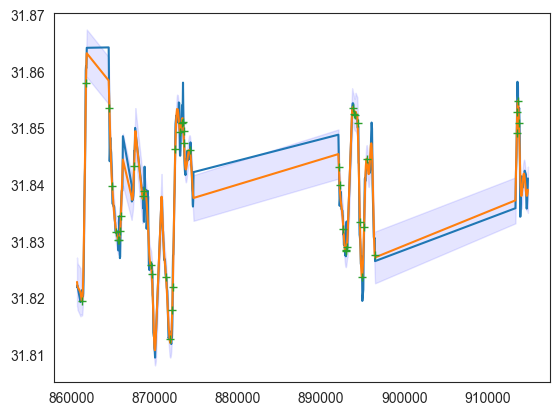

In [18]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


Xs_train = train['delta_abs_min'].to_numpy().reshape(-1,1)
ys_train1 = train['location-long'].to_numpy().reshape(-1, 1)
ys_train2 = train['location-lat'].to_numpy().reshape(-1, 1)

Xs_test  = test['delta_abs_min'].to_numpy().reshape(-1,1)
ys_test1  = test['location-long'].to_numpy().reshape(-1,1)
ys_test2  = test['location-lat'].to_numpy().reshape(-1,1)


kernel = 1 * RBF(length_scale=1) + WhiteKernel()
my_gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=10,
    alpha=.1
)    
my_gp.fit(Xs_train, ys_train1)
y_hat_lng1, y_var = my_gp.predict(Xs_test, return_std=True)
all_hat_lng, all_y_var = my_gp.predict(df2['delta_abs_min'].to_numpy().reshape(-1,1), return_std=True)


plt.plot(df2['delta_abs_min'], df2['location-long'], '-') 
plt.plot(df2['delta_abs_min'], all_hat_lng, '-') 

plt.plot(Xs_test, y_hat_lng1, '+') 

upper_bound = all_hat_lng + 1.96 * all_y_var
lower_bound = all_hat_lng - 1.96 * all_y_var
plt.fill_between(df2['delta_abs_min'], lower_bound, upper_bound, color = 'b', alpha = 0.1, label='95% confidence interval')

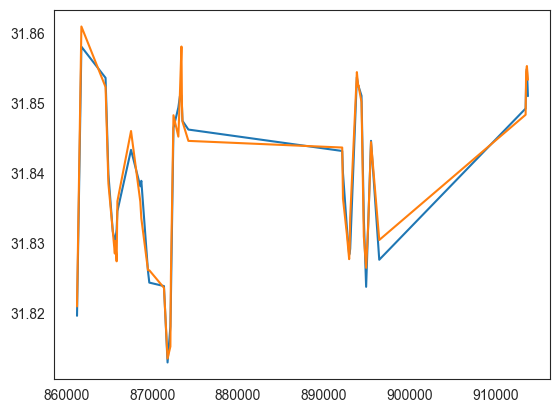

In [19]:
plt.plot(Xs_test, y_hat_lng1, '-') 
plt.plot(Xs_test, ys_test1, '-') 

 C:\research\wildlife\ee\pythonProject\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


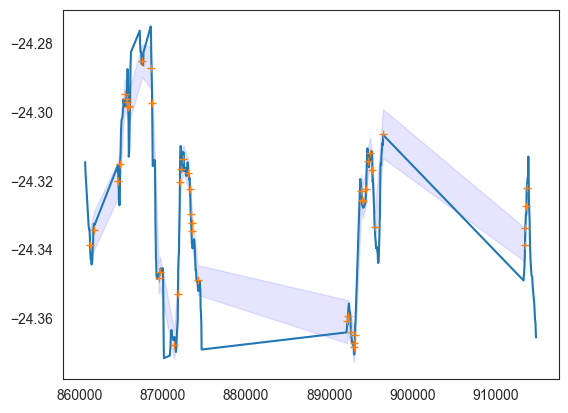

In [20]:
my_gp.fit(Xs_train, ys_train2)
y_hat_lng2, y_var = my_gp.predict(Xs_test, return_std=True)

plt.plot(df2['delta_abs_min'], df2['location-lat'], '-') 
plt.plot(Xs_test, y_hat_lng2, '+') 

upper_bound = y_hat_lng2 + 1.96 * y_var
lower_bound = y_hat_lng2 - 1.96 * y_var
plt.fill_between(test['delta_abs_min'].to_numpy(), lower_bound, upper_bound, color = 'b', alpha = 0.1, label='95% confidence interval')

Text(0, 0.5, 'Gap in KM')

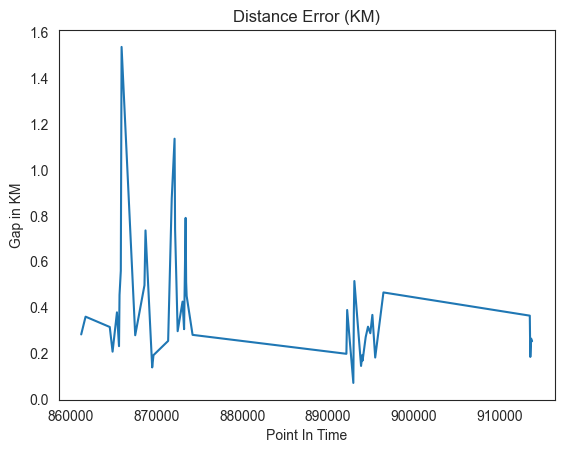

In [21]:
dist = []
i = 0
for index, row in test.iterrows():
    dist.append( GD((row['location-lat'], row['location-long']),(y_hat_lng2[i],y_hat_lng1[i])).km)
    i = i+1
    #test.at[index,'distance'] = GD((row['location-lat'], row['location-long']),first_row).km
#y_hat_lng1
#dist = df.at[index,'distance'] = GD((row['location-lat'], row['location-long']),first_row).km
plt.plot(test['delta_abs_min'], dist, '-') 
plt.title('Distance Error (KM)')
plt.xlabel("Point In Time")
plt.ylabel("Gap in KM")

# Now Lets Test RANDOM FOURIER FEATURES

In [22]:
from rfflearn import utils 
import rfflearn.cpu as rfflearn
args = {}
args["--n_test"] = TEST_SIZE
args["--n_train"] = TRAIN_SIZE
args["--kdim"] = 1999
args["--std_kernel"] = 50
args["--std_error"] = 11
args["--seed"] = 111


Xs_train = train['delta_abs_normalized'].to_numpy().reshape(-1,1)
ys_train1 = train['location-long'].to_numpy().reshape(-1, 1)
y_train_mean1 = ys_train1.mean(axis = 0)
ys_train1 = ys_train1 - y_train_mean1

ys_train2 = train['location-lat'].to_numpy().reshape(-1, 1)
y_train_mean2 = ys_train2.mean(axis = 0)
ys_train2 = ys_train2 - y_train_mean2

Xs_test  = test['delta_abs_normalized'].to_numpy().reshape(-1,1)
ys_test1  = test['location-long'].to_numpy().reshape(-1,1)
ys_test1 = ys_test1 - y_train_mean1

ys_test2  = test['location-lat'].to_numpy().reshape(-1,1)
ys_test2 = ys_test2 - y_train_mean2


GPR learning: 968.665123 [ms]
GPR inference: 15.622139 [us]
R2 score: 0.5946688510331232
Drawing figure: 0.048407 [s]


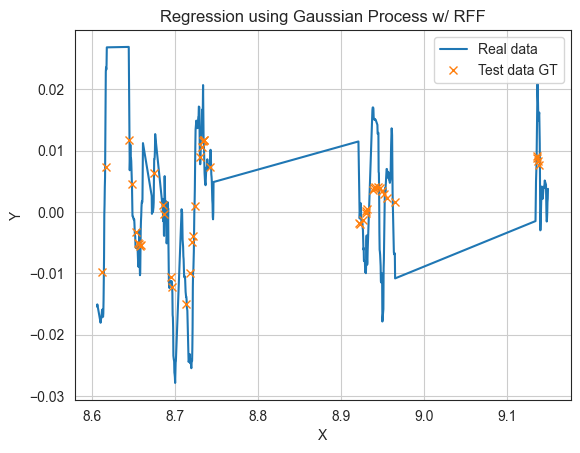

In [23]:
rfflearn.seed(100)
gpr = rfflearn.RFFGPR(args["--kdim"], args["--std_kernel"], std_error = args["--std_error"])

with utils.Timer("GPR learning: ", unit = "ms"):
    gpr.fit(Xs_train, ys_train1)
    
with utils.Timer("GPR inference: ", unit = "us", devide_by = 1000):
            pred1, pcov = gpr.predict(Xs_test, return_cov = True)
            pred1 = pred1.reshape((pred1.shape[0],))
            pstd = np.diag(pcov).reshape((pred1.shape[0],))

print("R2 score:", gpr.score(Xs_test, ys_test1))

with utils.Timer("Drawing figure: "):
    plt.figure()
    plt.title("Regression using Gaussian Process w/ RFF")
    plt.xlabel("X")
    plt.ylabel("Y")
    #plt.plot(Xs_train, ys_train, "+")
    #plt.plot(Xs_train,  ys_train1,  "-")
    plt.plot(df2['delta_abs_normalized'], df2['location-long']-y_train_mean1, '-') 
    plt.plot(Xs_test,  pred1,     "x")
    #if pstd is not None:
    #    mpl.fill_between(Xs_test.reshape((Xs_test.shape[0],)),  pred - pstd, pred + pstd, facecolor = "#DDDDDD")
    plt.legend(["Real data", "Test data GT", "Prediction", "1-sigma area"])
    plt.grid()

GPR learning: 1137.971878 [ms]
GPR inference: 17.745018 [us]
R2 score: 0.828337258892541
Drawing figure: 0.031244 [s]


NameError: name 'pred' is not defined

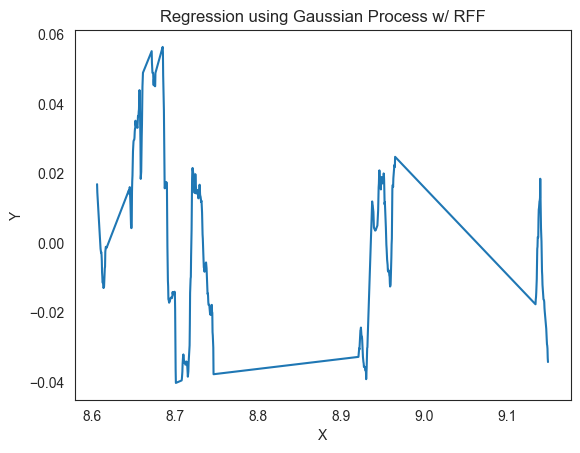

In [24]:
rfflearn.seed(100)
gpr = rfflearn.RFFGPR(args["--kdim"], args["--std_kernel"], std_error = args["--std_error"])

with utils.Timer("GPR learning: ", unit = "ms"):
    gpr.fit(Xs_train, ys_train2)
    
with utils.Timer("GPR inference: ", unit = "us", devide_by = 1000):
            pred2, pcov = gpr.predict(Xs_test, return_cov = True)
            pred2 = pred2.reshape((pred2.shape[0],))
            pstd = np.diag(pcov).reshape((pred2.shape[0],))

print("R2 score:", gpr.score(Xs_test, ys_test2))

with utils.Timer("Drawing figure: "):
    plt.figure()
    plt.title("Regression using Gaussian Process w/ RFF")
    plt.xlabel("X")
    plt.ylabel("Y")
    #plt.plot(Xs_train, ys_train, "+")
    #plt.plot(Xs_train,  ys_train2,  "-")
    plt.plot(df2['delta_abs_normalized'], df2['location-lat']-y_train_mean2, '-') 

    plt.plot(Xs_test,  pred,     "x")
    plt.plot(Xs_test,  ys_test2,     "+")
    #if pstd is not None:
    #    mpl.fill_between(Xs_test.reshape((Xs_test.shape[0],)),  pred - pstd, pred + pstd, facecolor = "#DDDDDD")
    plt.legend(["Real data", "Predicted Points", "Test Points", "1-sigma area"])
    plt.grid()

In [ ]:
dist = []
i = 0
for index, row in test.iterrows():
    dist.append( GD((row['location-lat'], row['location-long']),(pred2[i]+y_train_mean2,pred1[i]+y_train_mean1)).km)
    i = i+1

plt.plot(test['delta_abs_min'], dist, '-') 
plt.title('Distance Error (KM)')
plt.xlabel("Point In Time")
plt.ylabel("Gap in KM")
pred1

# Test with largest cluster

In [ ]:
df2 = df[df['cluster'] == 0]
df2["delta_abs_normalized"] = df2["delta_abs"] /100000/60
df2["delta_abs_min"] = df2["delta_abs"] /60/1000

train, test = train_test_split(df2, test_size=0.1)
train = train.sort_values(by='delta_abs', ascending=True)
test = test.sort_values(by='delta_abs', ascending=True)

TRAIN_SIZE = len(train)
TEST_SIZE = len(test)
print ("Train size =", TRAIN_SIZE, " Test size=", TEST_SIZE)

In [ ]:
Xs_train = train['delta_abs_min'].to_numpy().reshape(-1,1)
ys_train1 = train['location-long'].to_numpy().reshape(-1, 1)
y_train_mean1 = ys_train1.mean(axis = 0)
ys_train1 = ys_train1 - y_train_mean1

ys_train2 = train['location-lat'].to_numpy().reshape(-1, 1)
y_train_mean2 = ys_train2.mean(axis = 0)
ys_train2 = ys_train2 - y_train_mean2

Xs_test  = test['delta_abs_min'].to_numpy().reshape(-1,1)
ys_test1  = test['location-long'].to_numpy().reshape(-1,1)
ys_test1 = ys_test1 - y_train_mean1

ys_test2  = test['location-lat'].to_numpy().reshape(-1,1)
ys_test2 = ys_test2 - y_train_mean2

In [ ]:
from rfflearn import utils 
import rfflearn.cpu as rfflearn
args = {}
args["--n_test"] = TEST_SIZE
args["--n_train"] = TRAIN_SIZE
args["--kdim"] = 2999
args["--std_kernel"] = 100
args["--std_error"] = 1
args["--seed"] = 111


rfflearn.seed(100)
gpr = rfflearn.RFFGPR(args["--kdim"], args["--std_kernel"], std_error = args["--std_error"])

with utils.Timer("GPR learning: ", unit = "ms"):
    gpr.fit(Xs_train, ys_train1)
    
with utils.Timer("GPR inference: ", unit = "us", devide_by = 1000):
            pred, pcov = gpr.predict(Xs_test, return_cov = True)
            pred = pred.reshape((pred.shape[0],))
            pstd = np.diag(pcov).reshape((pred.shape[0],))

print("R2 score:", gpr.score(Xs_test, ys_test1))

with utils.Timer("Drawing figure: "):
    plt.figure()
    plt.title("Regression using Gaussian Process w/ RFF")
    plt.xlabel("X")
    plt.ylabel("Y")
    #plt.plot(Xs_train, ys_train, "+")
    plt.plot(df2["delta_abs_min"],  df2["location-long"],  "-")
    plt.plot(Xs_test,  pred+y_train_mean1,     "x")
    #plt.plot(Xs_test,  ys_test1+y_train_mean1,     "+")

    #if pstd is not None:
    #    mpl.fill_between(Xs_test.reshape((Xs_test.shape[0],)),  pred - pstd, pred + pstd, facecolor = "#DDDDDD")
    plt.legend(["Training data", "Test data GT", "Prediction", "1-sigma area"])
    plt.grid()